# **Retail Product Reviews using NLP**

This project draws insights from product-reviews from the Women's clothing brand, Fashion Nova using Natural Language Processing (NLP), applies sentiment analysis to find opinion of customer and topic Modelling to find latent topics.


**Data Dictionary**

Reviewer Name: Person writing the review

Reviewer Title: Title the reviewer wrote

Country: Country of Reviewer

Review Date: Datetime of review

Date of Experience: Datetime of purchase

Review Count: num of reviews from reviewers



In [ ]:
from google.colab import files
from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk import bigrams
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import gensim
import warnings
warnings.filterwarnings('ignore')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
import io

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
uploaded = files.upload()

Saving fashionnova_reviews.csv to fashionnova_reviews.csv
Saving iso_2digit_alpha_country_codes.csv to iso_2digit_alpha_country_codes.csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['fashionnova_reviews.csv']))
df.head()


,Reviewer Name,Profile Link,Country,Review Count,Review Date,Rating,Review Title,Review Text,Date of Experience
0,Champagne,/users/66c78240087b6269ffbcb5fb,US,1 review,2024-08-22T20:24:02.000Z,Rated 5 out of 5 stars,I love ordering from fashion nova,I love ordering from fashion nova. The clothes...,"August 22, 2024"
1,Vg customer,/users/6618fdb53d4198001210cbe7,VG,3 reviews,2024-08-21T05:43:11.000Z,Rated 5 out of 5 stars,Top tier content for fashion nova,Always amazing clothes and the fast shipping i...,"August 18, 2024"
2,Colleen Burgher,/users/64e9595206be1a001244ff73,US,3 reviews,2024-08-21T17:09:14.000Z,Rated 5 out of 5 stars,Prices and quality of products are…,Prices and quality of products are GREAT Would...,"August 21, 2024"
3,R.G.M,/users/66c58ad1c6ab36352a08f57a,US,1 review,2024-08-21T08:36:03.000Z,Rated 5 out of 5 stars,Great customer service,Great customer service. I was helped until the...,"August 20, 2024"
4,Rosalyn Cousar,/users/60ad4b6ef3788e001adbb8e3,US,5 reviews,2024-08-22T00:46:16.000Z,Rated 3 out of 5 stars,False advertising,Disappointing experience. You don’t live up to...,"August 21, 2024"


In [ ]:
df_iso2 = pd.read_csv(io.BytesIO(uploaded['iso_2digit_alpha_country_codes.csv']))
df_iso2.head()

,Country,Country Name
0,AF,Afghanistan
1,AX,Aland Islands
2,AL,Albania
3,DZ,Algeria
4,AS,American Samoa


#### **Data Cleaning and Feature Engineering**

In [ ]:
df =df.merge(df_iso2, on='Country')

In [ ]:
df.columns

Index(['Reviewer Name', 'Profile Link', 'Country', 'Review Count',
       'Review Date', 'Rating', 'Review Title', 'Review Text',
       'Date of Experience', 'Country Name'],
      dtype='object')

In [ ]:
df = df.drop(['Profile Link'],axis=1)

In [ ]:
df.isnull().sum()

,0
Reviewer Name,63
Country,4
Review Count,0
Review Date,0
Rating,0
Review Title,48
Review Text,0
Date of Experience,0
Country Name,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131980 entries, 0 to 131979
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Reviewer Name       131917 non-null  object
 1   Country             131976 non-null  object
 2   Review Count        131980 non-null  object
 3   Review Date         131980 non-null  object
 4   Rating              131980 non-null  object
 5   Review Title        131932 non-null  object
 6   Review Text         131980 non-null  object
 7   Date of Experience  131980 non-null  object
 8   Country Name        131980 non-null  object
dtypes: object(9)
memory usage: 9.1+ MB


In [ ]:
df['review_count_ex']= df['Review Count'].str.extract('(\d+)').astype(int)
df.head()

,Reviewer Name,Country,Review Count,Review Date,Rating,Review Title,Review Text,Date of Experience,Country Name,review_count_ex
0,Champagne,US,1 review,2024-08-22T20:24:02.000Z,Rated 5 out of 5 stars,I love ordering from fashion nova,I love ordering from fashion nova. The clothes...,"August 22, 2024",United States,1
1,Colleen Burgher,US,3 reviews,2024-08-21T17:09:14.000Z,Rated 5 out of 5 stars,Prices and quality of products are…,Prices and quality of products are GREAT Would...,"August 21, 2024",United States,3
2,R.G.M,US,1 review,2024-08-21T08:36:03.000Z,Rated 5 out of 5 stars,Great customer service,Great customer service. I was helped until the...,"August 20, 2024",United States,1
3,Rosalyn Cousar,US,5 reviews,2024-08-22T00:46:16.000Z,Rated 3 out of 5 stars,False advertising,Disappointing experience. You don’t live up to...,"August 21, 2024",United States,5
4,Kim Weatherspoon,US,2 reviews,2024-08-15T07:02:43.000Z,Rated 5 out of 5 stars,Love the sales,"Love the sales, and huge discounts. The variet...","August 14, 2024",United States,2


In [ ]:
df['rating_value'] = df['Rating'].str.extract('Rated (\d+)').astype(int)


In [ ]:
df['review_date_n'] = pd.to_datetime(df['Review Date'], format='%Y-%m-%dT%H:%M:%S.%fZ').dt.normalize()
df['Date_of_Experience_n'] = pd.to_datetime(df['Date of Experience'], format='%B %d, %Y')
df['days_between_reveiwed_and_purchase'] = (df['review_date_n'] - df['Date_of_Experience_n']).dt.days
df['month_of_review'] = df['review_date_n'].dt.strftime('%B')
df['year_of_review'] = df['review_date_n'].dt.year
df['month_year'] = df['review_date_n'].dt.strftime('%B %Y')
# Display the DataFrame
df.head()

,Reviewer Name,Country,Review Count,Review Date,Rating,Review Title,Review Text,Date of Experience,Country Name,review_count_ex,rating_value,review_date_n,Date_of_Experience_n,days_between_reveiwed_and_purchase,month_of_review,year_of_review,month_year
0,Champagne,US,1 review,2024-08-22T20:24:02.000Z,Rated 5 out of 5 stars,I love ordering from fashion nova,I love ordering from fashion nova. The clothes...,"August 22, 2024",United States,1,5,2024-08-22,2024-08-22,0,August,2024,August 2024
1,Colleen Burgher,US,3 reviews,2024-08-21T17:09:14.000Z,Rated 5 out of 5 stars,Prices and quality of products are…,Prices and quality of products are GREAT Would...,"August 21, 2024",United States,3,5,2024-08-21,2024-08-21,0,August,2024,August 2024
2,R.G.M,US,1 review,2024-08-21T08:36:03.000Z,Rated 5 out of 5 stars,Great customer service,Great customer service. I was helped until the...,"August 20, 2024",United States,1,5,2024-08-21,2024-08-20,1,August,2024,August 2024
3,Rosalyn Cousar,US,5 reviews,2024-08-22T00:46:16.000Z,Rated 3 out of 5 stars,False advertising,Disappointing experience. You don’t live up to...,"August 21, 2024",United States,5,3,2024-08-22,2024-08-21,1,August,2024,August 2024
4,Kim Weatherspoon,US,2 reviews,2024-08-15T07:02:43.000Z,Rated 5 out of 5 stars,Love the sales,"Love the sales, and huge discounts. The variet...","August 14, 2024",United States,2,5,2024-08-15,2024-08-14,1,August,2024,August 2024


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131980 entries, 0 to 131979
Data columns (total 17 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   Reviewer Name                       131917 non-null  object        
 1   Country                             131976 non-null  object        
 2   Review Count                        131980 non-null  object        
 3   Review Date                         131980 non-null  object        
 4   Rating                              131980 non-null  object        
 5   Review Title                        131932 non-null  object        
 6   Review Text                         131980 non-null  object        
 7   Date of Experience                  131980 non-null  object        
 8   Country Name                        131980 non-null  object        
 9   review_count_ex                     131980 non-null  int64         
 10  rating_v

Text preprocessing

In [ ]:
# create preprocess_text function
def preprocess_text(text):

    # Tokenize the text

    tokens = word_tokenize(text.lower())

    # Remove stop words

    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

    # remove specific words, that we are implied

    implied_words = ['fashion','nova','review','text','fashionnova']
    filtered_tokens = [token for token in filtered_tokens if token not in implied_words]

    # Lemmatize the tokens

    lemmatizer = WordNetLemmatizer()

    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    #remove punctuations
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    lemmatized_tokens = [token for token in lemmatized_tokens if token not in punctuations]


    # Join the tokens back into a string

    processed_text = ' '.join(lemmatized_tokens)

    return processed_text

# apply the function df

df['Review_Text_ppd'] = df['Review Text'].apply(preprocess_text)

In [ ]:
df.head()

,Reviewer Name,Country,Review Count,Review Date,Rating,Review Title,Review Text,Date of Experience,Country Name,review_count_ex,rating_value,review_date_n,Date_of_Experience_n,days_between_reveiwed_and_purchase,month_of_review,year_of_review,month_year,Review_Text_ppd
0,Champagne,US,1 review,2024-08-22T20:24:02.000Z,Rated 5 out of 5 stars,I love ordering from fashion nova,I love ordering from fashion nova. The clothes...,"August 22, 2024",United States,1,5,2024-08-22,2024-08-22,0,August,2024,August 2024,love ordering clothes good quality long read r...
1,Colleen Burgher,US,3 reviews,2024-08-21T17:09:14.000Z,Rated 5 out of 5 stars,Prices and quality of products are…,Prices and quality of products are GREAT Would...,"August 21, 2024",United States,3,5,2024-08-21,2024-08-21,0,August,2024,August 2024,price quality product great would love see cas...
2,R.G.M,US,1 review,2024-08-21T08:36:03.000Z,Rated 5 out of 5 stars,Great customer service,Great customer service. I was helped until the...,"August 20, 2024",United States,1,5,2024-08-21,2024-08-20,1,August,2024,August 2024,great customer service helped able provide sol...
3,Rosalyn Cousar,US,5 reviews,2024-08-22T00:46:16.000Z,Rated 3 out of 5 stars,False advertising,Disappointing experience. You don’t live up to...,"August 21, 2024",United States,5,3,2024-08-22,2024-08-21,1,August,2024,August 2024,disappointing experience ’ live advertising bo...
4,Kim Weatherspoon,US,2 reviews,2024-08-15T07:02:43.000Z,Rated 5 out of 5 stars,Love the sales,"Love the sales, and huge discounts. The variet...","August 14, 2024",United States,2,5,2024-08-15,2024-08-14,1,August,2024,August 2024,love sale huge discount variety quality win ev...


In [ ]:
# initialize NLTK sentiment analyzer

analyzer = SentimentIntensityAnalyzer()


# create get_sentiment function

def get_sentiment(text):

    scores = analyzer.polarity_scores(text)

    sentiment = 1 if scores['pos'] > 0 else 0

    return sentiment




# apply get_sentiment function

df['sentiment_review_text'] = df['Review_Text_ppd'].apply(get_sentiment)

In [ ]:
df.sentiment_review_text.value_counts()

,count
sentiment_review_text,
1,80083
0,51897


In [ ]:
df['word_count'] = df['Review_Text_ppd'].apply(lambda x: len(word_tokenize(x)))
total_words = df['word_count'].sum()
average_words_per_review = df['word_count'].mean()

EDA

In [ ]:
print(f"Date range of dataset between {df.review_date_n.min()} and {df.review_date_n.max()}")
print('Num of Reviews:', df.shape[0])
print('Num of Reviewers:', df['Reviewer Name'].nunique())
print('Num of Countries:', df['Country Name'].nunique())
print(f"Total number of words: {total_words}")
print(f"Average number of words per review: {average_words_per_review}")

Date range of dataset between 2016-11-27 00:00:00 and 2024-08-23 00:00:00
Num of Reviews: 131980
Num of Reviewers: 111453
Num of Countries: 182
Total number of words: 1184537
Average number of words per review: 8.975125018942263


correlation analysis
#missing

In [ ]:
country=df.groupby('Country Name')['rating_value']
country.describe().head(10).sort_values(by='count',ascending=False)

,count,mean,std,min,25%,50%,75%,max
Country Name,,,,,,,,
Antigua and Barbuda,42.0,4.142857,1.317267,1.0,4.00,5.0,5.0,5.0
Albania,17.0,3.588235,1.804814,1.0,2.00,5.0,5.0,5.0
Aruba,16.0,3.937500,1.768945,1.0,3.25,5.0,5.0,5.0
Angola,14.0,4.000000,1.467599,1.0,3.25,5.0,5.0,5.0
Anguilla,13.0,4.000000,1.632993,1.0,3.00,5.0,5.0,5.0
Argentina,6.0,4.333333,1.211060,2.0,4.25,5.0,5.0,5.0
Algeria,5.0,4.400000,0.894427,3.0,4.00,5.0,5.0,5.0
Afghanistan,2.0,3.000000,2.828427,1.0,2.00,3.0,4.0,5.0
American Samoa,2.0,5.000000,0.000000,5.0,5.00,5.0,5.0,5.0


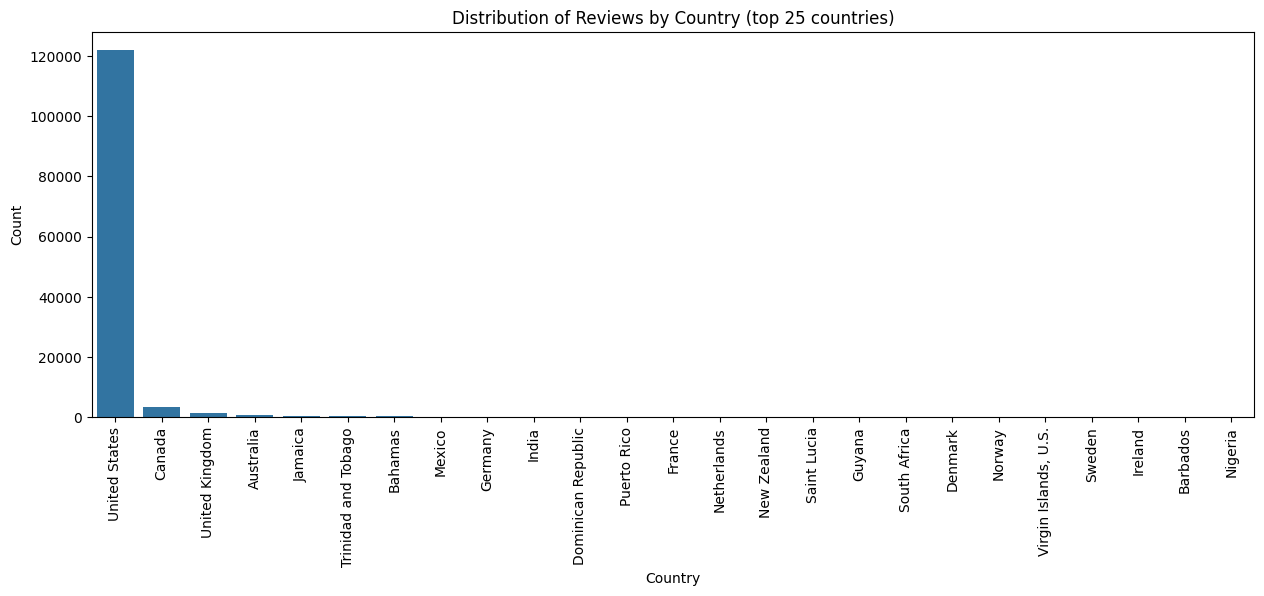

In [ ]:
plt.figure(figsize=(15, 5))
sns.countplot(data=df, x='Country Name', order=df['Country Name'].value_counts().head(25).index)
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Distribution of Reviews by Country (top 25 countries)')
plt.show()

<Axes: xlabel='Country Name', ylabel='count'>

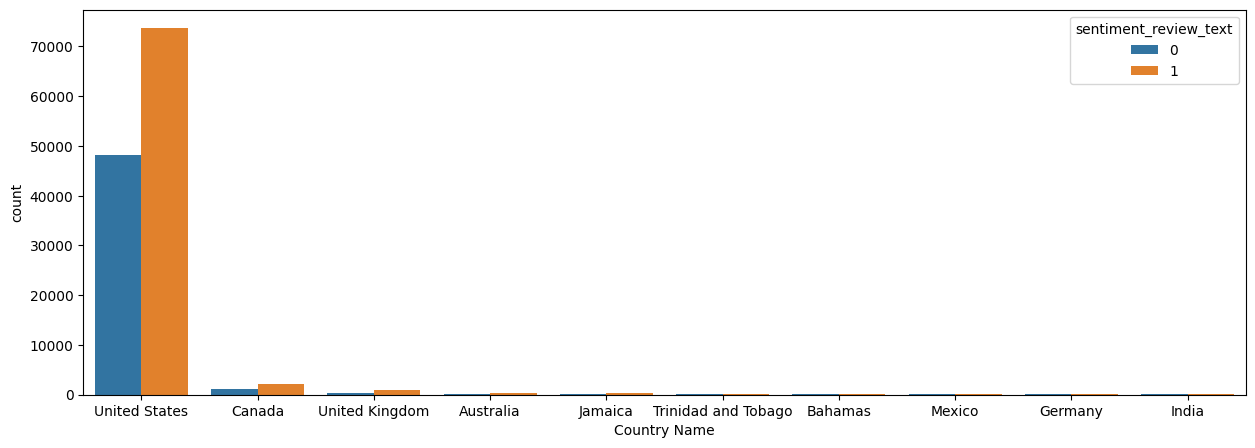

In [ ]:
plt.figure(figsize=(15, 5))
sns.countplot(df,x='Country Name',hue='sentiment_review_text',order=df['Country Name'].value_counts().head(10).index)

In [ ]:
df.Country.value_counts().sort_values(ascending=False)

,count
Country,
US,121912
CA,3296
GB,1252
AU,543
JM,504
...,...
FK,1
MO,1
TG,1


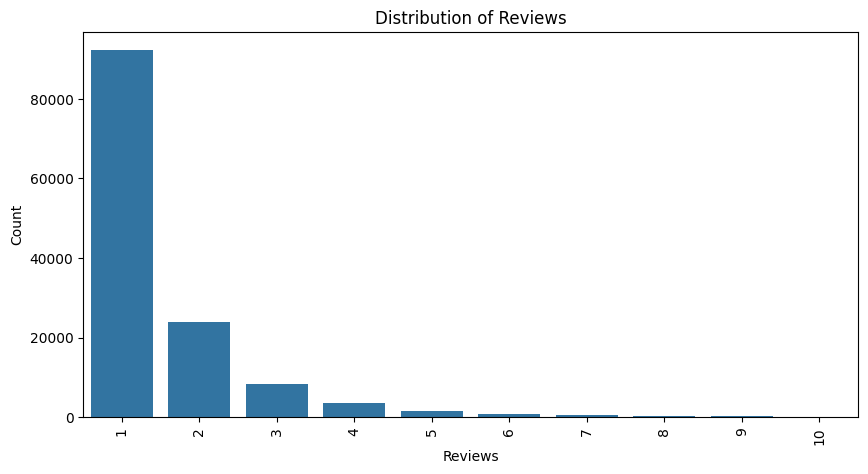

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='review_count_ex', order=df['review_count_ex'].value_counts().head(10).index)
plt.xticks(rotation=90)
plt.xlabel('Reviews')
plt.ylabel('Count')
plt.title('Distribution of Reviews')
plt.show()

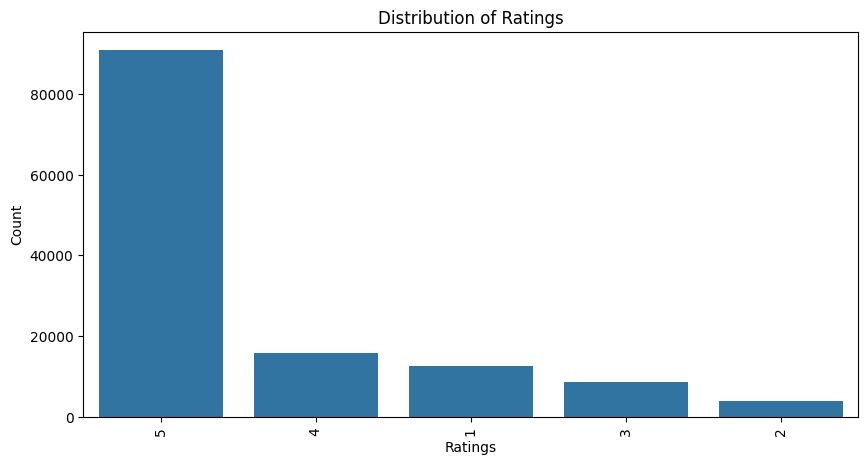

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='rating_value', order=df['rating_value'].value_counts().head(10).index)
plt.xticks(rotation=90)
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()

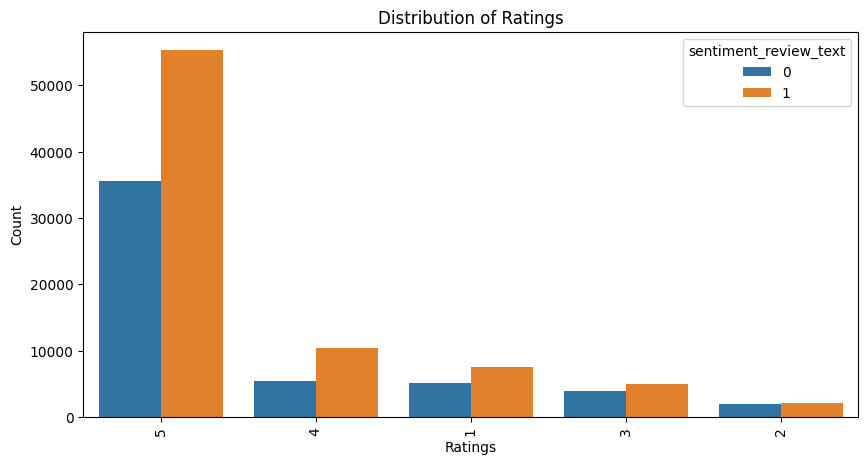

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='rating_value', hue= 'sentiment_review_text', order=df['rating_value'].value_counts().head(10).index)
plt.xticks(rotation=90)
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()

In [ ]:
df.columns

Index(['Reviewer Name', 'Country', 'Review Count', 'Review Date', 'Rating',
       'Review Title', 'Review Text', 'Date of Experience', 'Country Name',
       'review_count_ex', 'rating_value', 'review_date_n',
       'Date_of_Experience_n', 'days_between_reveiwed_and_purchase',
       'month_of_review', 'year_of_review', 'month_year', 'Review_Text_ppd',
       'sentiment_review_text', 'word_count'],
      dtype='object')

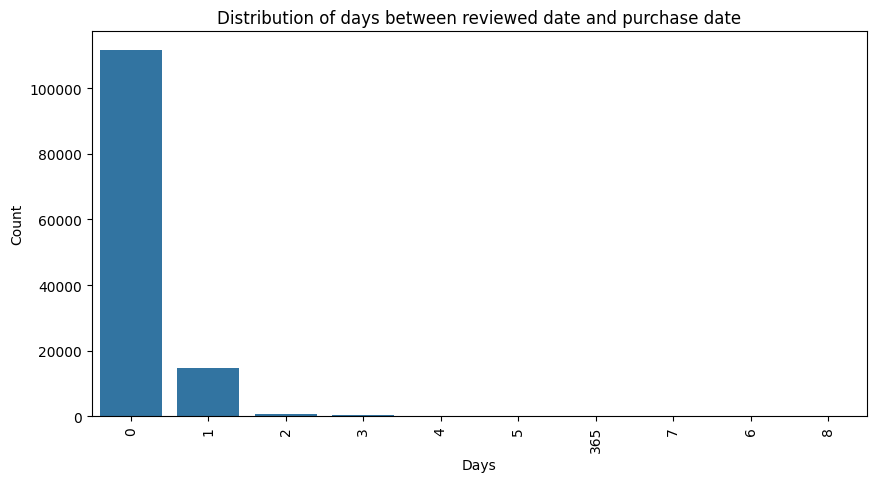

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='days_between_reveiwed_and_purchase', order=df['days_between_reveiwed_and_purchase'].value_counts().head(10).index)
plt.xticks(rotation=90)
plt.xlabel('Days')
plt.ylabel('Count')
plt.title('Distribution of days between reviewed date and purchase date')
plt.show()

In [ ]:
df.columns

Index(['Reviewer Name', 'Country', 'Review Count', 'Review Date', 'Rating',
       'Review Title', 'Review Text', 'Date of Experience', 'Country Name',
       'review_count_ex', 'rating_value', 'review_date_n',
       'Date_of_Experience_n', 'days_between_reveiwed_and_purchase',
       'month_of_review', 'year_of_review', 'month_year', 'Review_Text_ppd',
       'sentiment_review_text', 'word_count'],
      dtype='object')

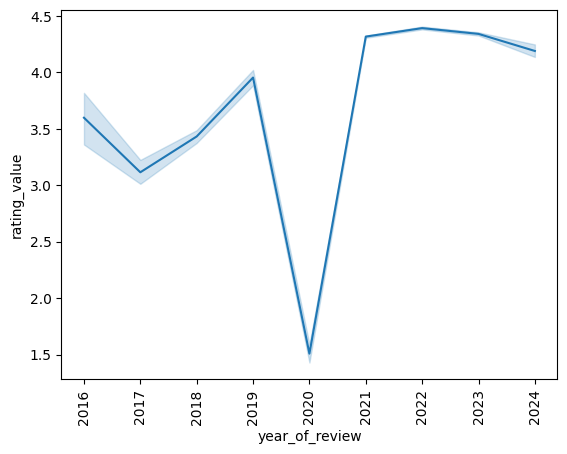

In [ ]:
#plt.subplot(1,2,figsize=[10, 5])
sns.lineplot(df,x='year_of_review', y='rating_value')
#sns.lineplot(df,x='month_of_review', y='rating_value')
plt.xticks(rotation=90);

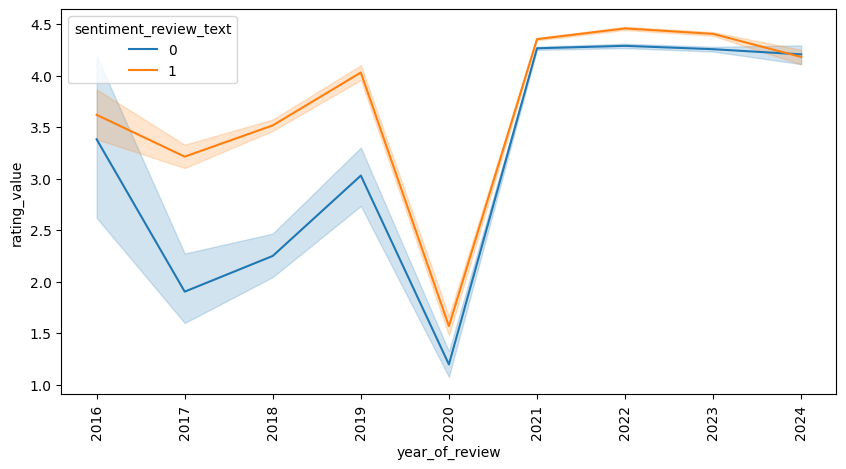

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='year_of_review', y='rating_value',hue='sentiment_review_text')
plt.xticks(rotation=90);

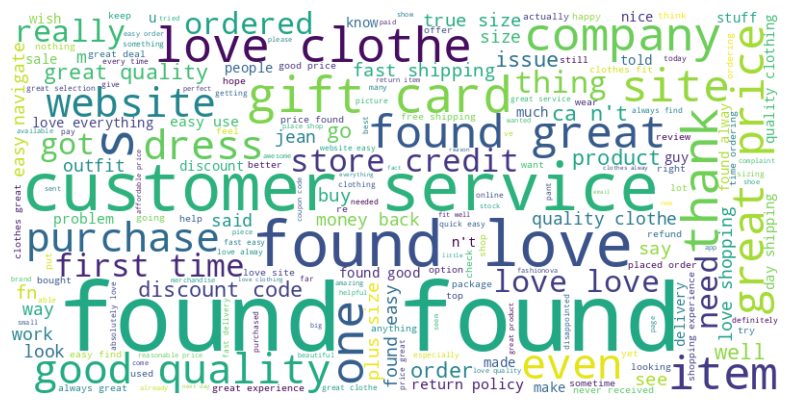

In [ ]:
wordcloud= WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['Review_Text_ppd']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

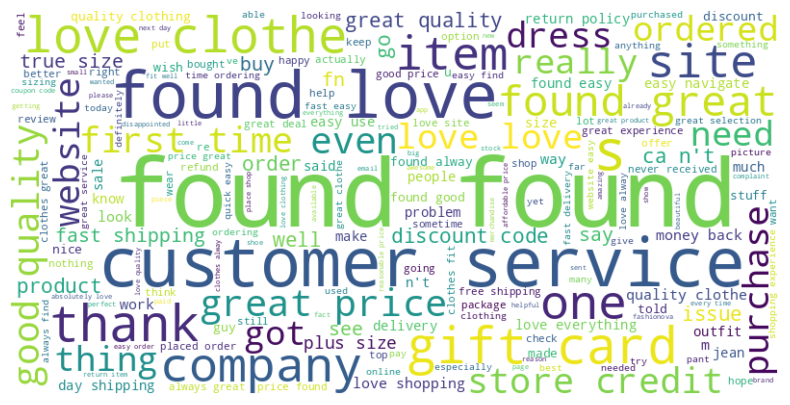

In [ ]:
wordcloud= WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['Review_Text_ppd']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
positive_reviews= df[df['sentiment_review_text']==1]['Review_Text_ppd']
negative_reviews = df[df['sentiment_review_text']==0]['Review_Text_ppd']

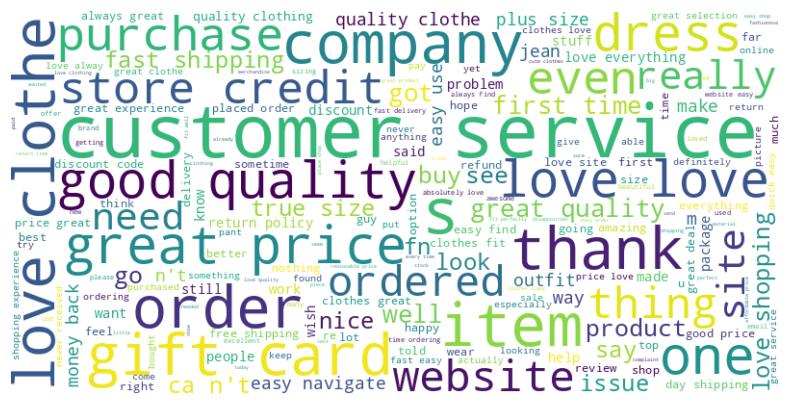

In [ ]:
wordcloud_pos =WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_reviews))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.show()

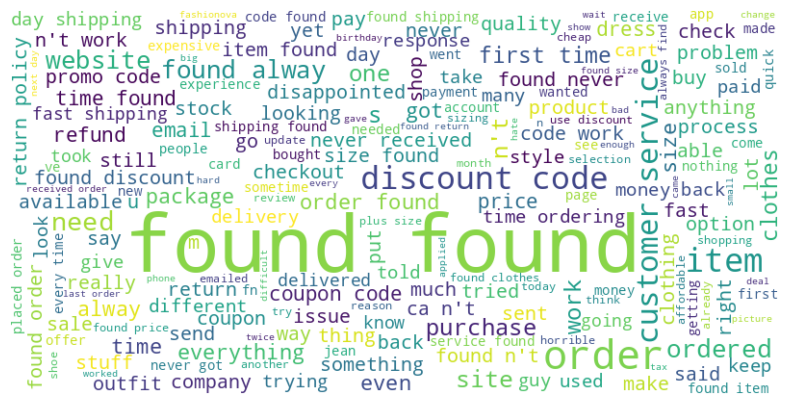

In [ ]:
wordcloud_pos =WordCloud(width=800, height=400, background_color='white').generate(' '.join(negative_reviews))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
all_words = []
df['Review_Text_ppd'].apply(lambda x: all_words.extend(word_tokenize(x.lower())))

# Step 2: Count the frequency of each word
word_freq = Counter(all_words)

# Step 3: Find the most common words
most_common_words = word_freq.most_common(10)  # Change the number to display more or fewer common words

# Display the most common words
print("Most common words:")
for word, freq in most_common_words:
    print(f"{word}: {freq}")

Most common words:
found: 39283
love: 26212
’: 20416
great: 19168
order: 17566
clothes: 14769
item: 14449
time: 12154
easy: 11183
good: 11172


Most frequently use 2 strings at the same time

In [ ]:
all_bigrams = []
df['Review_Text_ppd'].apply(lambda x: all_bigrams.extend(list(bigrams(word_tokenize(x.lower())))))

# Step 2: Count the frequency of each bigram
bigram_freq = Counter(all_bigrams)

# Step 3: Find the most common bigrams
most_common_bigrams = bigram_freq.most_common(10)  # Change the number to display more or fewer common bigrams

# Display the most common bigrams
print("Most common bigrams:")
for bigram, freq in most_common_bigrams:
    print(f"{bigram}: {freq}")

Most common bigrams:
('customer', 'service'): 4964
('love', 'clothes'): 2438
('gift', 'card'): 2414
('great', 'price'): 2117
('good', 'quality'): 1965
('first', 'time'): 1816
('store', 'credit'): 1805
('great', 'quality'): 1557
('discount', 'code'): 1519
('ca', "n't"): 1416


Topic Modelling is a technique to extract the hidden topics from large volumes of text. Latent Dirichlet Allocation (LDA) is a probabilistic model that generates a set of topics, each represented by a distribution over words, for a given corpus of documents.

In [ ]:
# Tokenize each review in the Series
tokenized_reviews = df['Review_Text_ppd'].apply(word_tokenize)

# Create the dictionary
dictionary = corpora.Dictionary(tokenized_reviews)

# Create the corpus
corpus = [dictionary.doc2bow(text) for text in tokenized_reviews]

lda_model =LdaModel(corpus=corpus,
                    id2word=dictionary,
                    num_topics=5,
                    random_state=42,
                    passes=10,
                    alpha='auto',
                    per_word_topics=True)

topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Coherence Score: {coherence_lda}')

(0, '0.029*"recommend" + 0.029*"looking" + 0.028*"worst" + 0.018*"friend" + 0.014*"confirmation"')
(1, '0.043*"email" + 0.019*"card" + 0.019*"code" + 0.019*"``" + 0.017*"sent"')
(2, '0.052*"love" + 0.041*"clothes" + 0.039*"great" + 0.033*"good" + 0.029*"quality"')
(3, '0.781*"found" + 0.007*"x" + 0.007*"exact" + 0.004*"improved" + 0.004*"view"')
(4, '0.031*"’" + 0.030*"order" + 0.019*"item" + 0.017*"time" + 0.015*"customer"')
Coherence Score: 0.678323450899745


**bold text**https://www.datacamp.com/tutorial/what-is-topic-modeling